In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sys 
sys.path.append("../../")
from proj_mod import drop_extreme

In [2]:
all_data=pd.read_csv("../../data/processed/all_data_collection.csv")
all_data.columns

Index(['Date', 'tech_index_daily_pro_change', 'cop_daily_pro_change',
       'gold_daily_pro_change', 'silv_daily_pro_change',
       'pal_daily_pro_change', 'plat_daily_pro_change',
       'crude_oil_daily_pro_change', 'fed_dff_daily',
       'ppi314_monthly_pro_change', 'ppi332_monthly_pro_change',
       'ppi333_monthly_pro_change', 'ppi334_monthly_pro_change',
       'ppi335_monthly_pro_change', 'ppi336_monthly_pro_change',
       'ppi339_monthly_pro_change', 'ppi516_monthly_pro_change',
       'ppi517_monthly_pro_change', 'ppi5132_monthly_pro_change',
       'ppi5182_monthly_pro_change'],
      dtype='object')

In [3]:
all_data_extended = all_data.copy(deep=True)

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

In [5]:
arr_mse_kfold_collection=[] #index zero is for the training with extreme values, and index one is for the training without extreme values. 
arr_mse_kfold_de_collection=[] #index zero is for the training with extreme values, and index one is for the training without extreme values. 
all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()
    
X_train=all_data_extended_train.iloc[:,2:]
y_train=all_data_extended_train.iloc[:,1]
spineline_pipe = Pipeline([
("std", StandardScaler()),               # 1) Standardize features
("spline", SplineTransformer(n_knots=2, degree=1)),
("regressor", LinearRegression())        # 2) Fit a regression model
])
time_kfold=TimeSeriesSplit(n_splits=5)
fold_mse=[]
fold_mse_de=[]
#First for without deleting extreme values. 
for index_train, index_test in time_kfold.split(X_train): 
    X_tt=X_train.iloc[index_train]
    y_tt=y_train.iloc[index_train]
    X_ho=X_train.iloc[index_test]
    y_ho=y_train.iloc[index_test]
    all_data_ho_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_test], fl_low=0.01, fl_high=0.99)
    X_ho_de=all_data_ho_de.iloc[:,2:]
    y_ho_de=all_data_ho_de.iloc[:,1]
    spineline_pipe.fit(X=X_tt,y=y_tt)
    pred=spineline_pipe.predict(X=X_ho)
    error=mean_squared_error(y_pred=pred,y_true=y_ho)
    fold_mse.append(error)
    pred_de=spineline_pipe.predict(X=X_ho_de)
    error_de=mean_squared_error(y_pred=pred_de,y_true=y_ho_de)
    fold_mse_de.append(error_de)
mean_error=np.mean(fold_mse)
arr_mse_kfold_collection.append([])
arr_mse_kfold_collection[-1].append(mean_error)
mean_error_de=np.mean(fold_mse_de)
arr_mse_kfold_de_collection.append([])
arr_mse_kfold_de_collection[-1].append(mean_error_de)
print("mse trained WITHOUT deleting extreme values is "+str(mean_error)+" with k fold.")
fold_mse=[]
fold_mse_de=[]
#Then the one with deleting extreme values. 
for index_train, index_test in time_kfold.split(X_train): 
    all_data_tt=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_train], fl_low=0.001, fl_high=0.999)  #all_data_extended_train.iloc[index_train]
    all_data_ho=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #all_data_extended_train.iloc[index_test]
    X_tt=all_data_tt.iloc[:,2:] #drop_extreme.drop_by_sort(df_in=X_train.iloc[index_train], fl_low=0.01, fl_high=0.99)     #X_de_train.iloc[index_train]
    y_tt=all_data_tt.iloc[:,1] #drop_extreme.drop_by_sort(df_in=y_train.iloc[index_train], fl_low=0.01, fl_high=0.99) 
    X_ho_de=all_data_ho.iloc[:,2:] #drop_extreme.drop_by_sort(df_in=X_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #X_train.iloc[index_test]
    y_ho_de=all_data_ho.iloc[:,1] #drop_extreme.drop_by_sort(df_in=y_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #y_train.iloc[index_test]
    X_ho=X_train.iloc[index_test]
    y_ho=y_train.iloc[index_test]
    spineline_pipe.fit(X=X_tt,y=y_tt)
    pred=spineline_pipe.predict(X=X_ho)
    error=mean_squared_error(y_pred=pred,y_true=y_ho)
    fold_mse.append(error)
    pred_de=spineline_pipe.predict(X=X_ho_de)
    error_de=mean_squared_error(y_pred=pred_de,y_true=y_ho_de)
    fold_mse_de.append(error_de)
mean_error=np.mean(fold_mse)
arr_mse_kfold_collection[-1].append(mean_error)
mean_error_de=np.mean(fold_mse_de)
arr_mse_kfold_de_collection[-1].append(mean_error_de)
print("mse trained WITH deleting extreme values is "+str(mean_error)+" with k fold.")
        

mse trained WITHOUT deleting extreme values is 2.0320833473198574 with k fold.
mse trained WITH deleting extreme values is 2.0413974367219887 with k fold.


In [6]:
arr_mse_kfold_collection

[[np.float64(2.0320833473198574), np.float64(2.0413974367219887)]]

In [7]:
arr_mse_kfold_de_collection

[[np.float64(1.5218322206045258), np.float64(1.5216090898845747)]]

In [8]:
arr_in=np.array(arr_mse_kfold_de_collection).transpose()
np.array(arr_mse_kfold_collection).transpose()

array([[2.03208335],
       [2.04139744]])

In [9]:
df_error=pd.DataFrame({"WITH extreme":np.array(arr_mse_kfold_collection).transpose()[0], "WITHOUT extreme":np.array(arr_mse_kfold_collection).transpose()[1]})

## We first train the one without extreme values, tested on both test data with and without extremes. 

In [10]:
all_data_extended = all_data.copy(deep=True)

In [11]:
all_data_extended_train_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train,fl_low=0.001,fl_high=0.999)
all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()
all_data_extended_test_de=drop_extreme.drop_by_sort(df_in=all_data_extended_test,fl_low=0.01,fl_high=0.99)

In [12]:
X_train=all_data_extended_train.iloc[:,2:]
y_train=all_data_extended_train.iloc[:,1]
X_de_train=all_data_extended_train_de.iloc[:,2:]
y_de_train=all_data_extended_train_de.iloc[:,1]
X_test=all_data_extended_test.iloc[:,2:]
y_test=all_data_extended_test.iloc[:,1]

In [13]:
X_de_test=all_data_extended_test_de.iloc[:,2:]
y_de_test=all_data_extended_test_de.iloc[:,1]

In [14]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),               # 1) Standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())        # 2) Fit a regression model
])

In [15]:
spineline_pipe.fit(X=X_de_train,y=y_de_train)

Pipeline(steps=[('std', StandardScaler()),
                ('spline', SplineTransformer(degree=1, n_knots=2)),
                ('regressor', LinearRegression())])

#### First, test on the test set with extreme values. 

In [16]:
pred_extreme=spineline_pipe.predict(X=X_test)
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)

#### Graph for trained without extreme, tested with extreme. 

In [17]:
print("mse (trained without extreme, tested with extreme) is ", mse_extreme)

mse (trained without extreme, tested with extreme) is  1.4930118250264264


<function matplotlib.pyplot.show(close=None, block=None)>

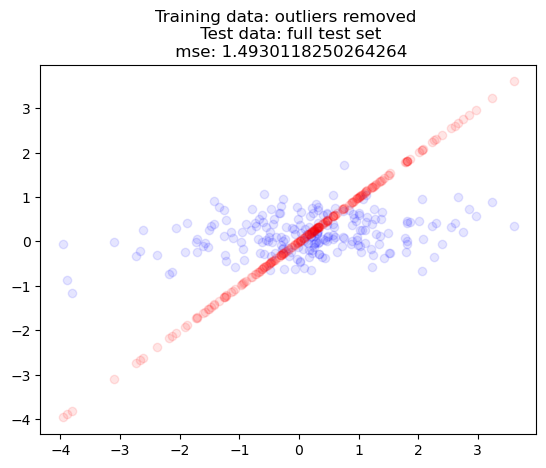

In [18]:
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.title(f"Training data: outliers removed \n Test data: full test set\n mse: {mse_extreme}")
plt.show

In [19]:
pred_noextreme=spineline_pipe.predict(X=X_de_test)

In [20]:
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

#### Graph for trained without extreme, tested without extreme. 

In [21]:
print("mse (trained without extreme, tested without extreme) is ", mse_noextreme)


mse (trained without extreme, tested without extreme) is  1.3473170335866287


<function matplotlib.pyplot.show(close=None, block=None)>

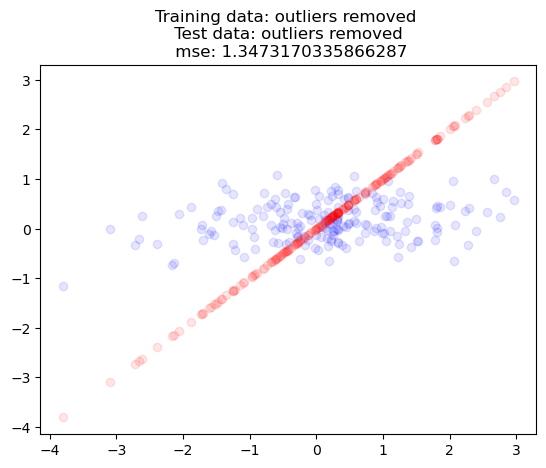

In [22]:
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.title(f"Training data: outliers removed \n Test data: outliers removed \n mse: {mse_noextreme}")
plt.show

In [23]:
all_data_train=all_data[all_data_extended["Date"]<"2024-01-01"]

In [24]:
all_data_test=all_data[all_data_extended["Date"]>="2024-01-01"]

In [25]:
all_data_test_de=drop_extreme.drop_by_sort(df_in=all_data_test,fl_low=0.01,fl_high=0.99)

In [26]:
X_train=all_data_train.iloc[:,2:]
y_train=all_data_train.iloc[:,1]
X_test=all_data_test.iloc[:,2:]
y_test=all_data_test.iloc[:,1]
X_de_test=all_data_test_de.iloc[:,2:]
y_de_test=all_data_test_de.iloc[:,1]

In [27]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),                  # standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())           # final estimator
])

In [28]:
spineline_pipe.fit(X=X_train,y=y_train)

Pipeline(steps=[('std', StandardScaler()),
                ('spline', SplineTransformer(degree=1, n_knots=2)),
                ('regressor', LinearRegression())])

In [29]:
pred_extreme=spineline_pipe.predict(X=X_test)
pred_noextreme=spineline_pipe.predict(X_de_test)
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

#### Graph for trained with extreme and tested with extreme. 

In [30]:
print("mse (trained with extreme and tested with extreme) is ", mse_extreme)

mse (trained with extreme and tested with extreme) is  1.5124739248435195


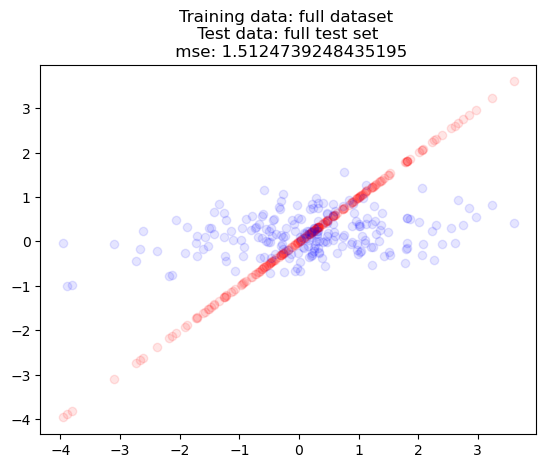

In [34]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.title(f"Training data: full dataset \n Test data: full test set \n mse: {mse_extreme}")
plt.show()

#### Graph for trained with extreme and tested with no extreme. 

In [32]:
print("mse (trained with extreme and tested with no extreme) is ", mse_noextreme)


mse (trained with extreme and tested with no extreme) is  1.3591363272625205


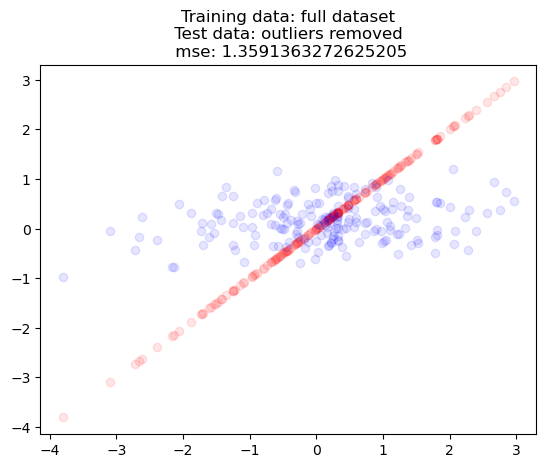

In [33]:
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.title(f"Training data: full dataset\n Test data: outliers removed \n mse: {mse_noextreme}")
plt.show()